# Цель Блокнота

Рассмотрение механизмов интерпритации моделей машинного обучения в рамках библиотеки `scikit-learn`
* Вспоминаем про `pipeline` и обработку признаков с помошью `StandardScaler` , `OneHotEncoder` и `TargetEncoder` для `SGDRegressor`, а также Предобразование целевой переменной с помощью класса `TransformedTargetRegressor`
* Анализ весов линейной регрессии
* Для анализа ошибок модели используем `PredictionErrorDisplay`
* Бустинг `CatBoost` и анализ значимых признаков и деревьев внутри
* Для более перспективной оценки значимости признаков используем `permutation_importance`
* Для анализа вклада отдельнго признака используем `PartialDependenceDisplay`
* Функция для сохранения метрик

# Import библиотек

Обновим `scikit-learn` чтобы воспользоваться некими новинками

Например `TargetEncoder`

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.7 MB/s eta 0:00:00


In [ ]:
# @title Гигантский блок импорта  { display-mode: "form" }

import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import plotly.graph_objects as go # Библиотека Plotly. Модуль "Graph Objects"
import plotly.express as px # Библиотека Plotly. Модуль "Express"

# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодированиеот scikit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

from sklearn.linear_model import SGDRegressor # Линейная регрессия с градиентным спуском от scikit-learn

from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay # Класс визуализации ошибок модели
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import TargetEncoder

from catboost import Pool
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

plt.style.use('grayscale')

# Набор данных


Набор данных представляет собой статистику параметров автомобилей на вторичном рынке в Молдавии.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный параметр.

Среди указанных параметров приведены целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди параметров есть целевой для задачи классификации - тип трансмиссии.

 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий параметр).

# Загрузка данных

Загружаем наши данные из файла по прямой ссылке на git-hub

In [ ]:
DF = pd.read_csv('https://raw.githubusercontent.com/dayekb/Basic_ML_Alg/main/cars_moldova_clean.csv', delimiter = ',')
DF

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32480,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32481,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32482,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32483,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


In [ ]:
# Добавим пару рандомных признаков для последующего анализа
DF['random_feature_1'] = np.random.random(size = DF.shape[0]) # равномерное распределение
DF['random_feature_2'] = np.random.normal(size = DF.shape[0]) # нормальное распределение

Список числовых и категориальных данных

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']

Предварительная обработка из [предыдущего блокнота](https://colab.research.google.com/drive/1es_OrShFiuaeOnlPjX2B1geHDM-XfofM?usp=sharing)

Из предварительной обработки исключена колонка `Price(euro)`, поскольку она является целевой меткой и будет обработана отдельно


In [ ]:
# @title Всякие там Pipeline { display-mode: "form" }


num_pipe_distance = Pipeline([
    ('scaler', StandardScaler())
])

num_distance = ['Distance']

num_pipe_engine = Pipeline([
    ('scaler', StandardScaler())
])

num_engine = ['Engine_capacity(cm3)']

num_pipe_year = Pipeline([
    ('power', PowerTransformer())
])

num_year = ['Year']

cat_pipe_transmission = Pipeline([
    ('encoder', OrdinalEncoder())

])

cat_transmission = ['Transmission']

cat_pipe_style_fuel = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))

])

cat_style_fuel = ['Style', 'Fuel_type']

cat_pipe_make_model = Pipeline([
    ('encoder', TargetEncoder(target_type="continuous")),
        ('scaler', StandardScaler())
])

cat_make_model = ['Make', 'Model']

random = ['random_feature_1', 'random_feature_2']



# Сделаем отдельно Pipeline с числовыми признаками
preprocessors_num = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year', num_pipe_year, num_year),
    ('random', "passthrough", random),
])

# и Pipeline со всеми признаками
preprocessors_all = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year', num_pipe_year, num_year),
    ('cat_transmission', cat_pipe_transmission, cat_transmission),
    ('cat_style_fuel', cat_pipe_style_fuel, cat_style_fuel),
    ('cat_make_model', cat_pipe_make_model, cat_make_model),
        ('random', "passthrough", random),
])

# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns_num = np.hstack([num_distance,
                    num_engine,
                    num_year, random])

In [ ]:
# @title Вспомагательные функции { display-mode: "form" }

def get_coefs (model):
    """Берем веса как атрибуты обученной модели.
    Входные переменные:
    ===========
    model: обученная модель
    """
    B0=model.intercept_[0]
    B=model.coef_
    return B0, B

def print_model (B0,B,features_names):
    """Написание уравнения модели.
    Входные переменные:
    ===========
    B0: смещение (независимый коэффициент)
    weights: веса признаков
    features_names: список названий признаков
    """
    line='{:.3f}'.format(B0)
    sign=['+','-']
    for p,(fn,b) in enumerate(zip(features_names,B)):
        line=line+sign[int(0.5*(np.sign(b)-1))]+'{:.2f}*'.format(np.abs(b))+fn

    print('Решение')
    print(line)

def vis_weigths(weights,features_names = None, width = 1200, height = 600):
    """Отрисовка весов.
    Входные переменные:
    ===========
    weights: веса признаков
    features_names: список названий признаков
    """
    numbers = np.arange(0,len(weights))                 # создаем массив от 0 до количество весов-1
    if features_names:
        tick_labels = np.hstack(['B0',features_names])
    else:
        tick_labels = ['B'+str(num) for num in numbers] # создаем "названия" весов

    ind = np.argsort(np.abs(weights))
    weights = weights[ind][::-1]

    fig = go.Figure()
    fig.add_trace(go.Bar(x=numbers[weights<0], y=weights[weights<0],
                    marker_color='red',
                    name='отрицательные веса'))
    fig.add_trace(go.Bar(x=numbers[weights>=0], y=weights[weights>=0],
                    marker_color='blue',
                    name='положительные веса'
                    ))

    fig.update_layout(
                title="Веса модели",
                width=width,
                height=height,
                template = "plotly_dark",
                xaxis = dict(
                                         tickmode = 'array',
                                         tickvals = numbers,
                                         ticktext = tick_labels[ind][::-1],
                                         )
                )

    fig.show()

def vis_weigths_threshold(weights, feature_names, threshold, width = 1200, height = 600):
    """Отрисовка весов с фильтром.
    Входные переменные:
    ===========
    weights: веса признаков
    features_names: список названий признаков
    threshold: порог "значимости" коэффициентов
    """
    # фильтруем веса коэффициентов
    mask = np.abs(weights) >= threshold
    weights_filtered = weights[mask]
    feature_names_filtered = [name for name, m in zip(feature_names, mask[1:]) if m]

    # Рисуем столбчатую диаграмму
    vis_weigths(weights_filtered,feature_names_filtered, width = width, height = height)

def calculate_metric(model_pipe, X, y, metric = r2_score, **kwargs):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model, **kwargs)


def cross_validation (X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])
    return DF_score

def analyse_linear_model(model, X_train, y_train, X_val, y_val, metrics, metric_names, scoring_reg, cv_rule, model_name = 'My_model', comments = 'Hello world'):
    B0, B = get_coefs(model)
    features_names = list(columns_num)
    print_model(B0,B,features_names)

    Bs = np.hstack([B0,B])
    vis_weigths(Bs,features_names)

    analyse_model(model, X_train, y_train, X_val, y_val, metrics, metric_names, scoring_reg, cv_rule, model_name, comments )


def analyse_model(model, X_train, y_train, X_val, y_val, metrics, metric_names, scoring_reg, cv_rule, model_name = 'My_model', comments = 'Hello world'):
    train_metrics = {}
    val_metrics = {}

    for name, metric,  in zip(metric_names, metrics):
        train_metric = calculate_metric(model, X_train, y_train, metric)
        val_metric = calculate_metric(model, X_val, y_val, metric)
        train_metrics[name] = train_metric
        val_metrics[name] = val_metric
        print(name+ f" на тренировочной выборке: {train_metric:.4f}")
        print(name+ f" на валидационной выборке: {val_metric:.4f}")

    cv_metrics = cross_validation (X_train, y_train,
                    model,
                    scoring_reg,
                    cv_rule)

    save_result(model_name, train_metrics, val_metrics, cv_metrics, comments)

In [ ]:
# @title Функция для сохранения результата { display-mode: "form" }


def save_result(model_name, train_metrics, test_metrics, cv_metrics, comments=None):
    """
    Save the results of a model training to a Pandas DataFrame.

    Parameters:
    - model_name (str): Name of the model
    - train_metrics (dict): Metrics on the training set (e.g. {'f1': 0.8, 'acc': 0.9})
    - test_metrics (dict): Metrics on the test set (e.g. {'f1': 0.7, 'acc': 0.8})
    - cv_metrics (dict): Metrics on cross-validation (e.g. {'f1': [0.7, 0.8, 0.9], 'acc': [0.8, 0.9, 0.95]})
    - comments (str, optional): User comments (default=None)

    Returns:
    - None (appends to the DataFrame)
    """
    # Create a dictionary to store the results
    result = {
        'Model': model_name,
        'Comments': comments
    }

    # Add train metrics to the result dictionary
    for metric_name, metric_value in train_metrics.items():
        result[f'Train {metric_name}'] = metric_value

    # Add test metrics to the result dictionary
    for metric_name, metric_value in test_metrics.items():
        result[f'Val {metric_name}'] = metric_value

    # Add CV metrics to the result dictionary
    for metric_name, metric_values in cv_metrics.iloc[:,2:].items():
        result[f'CV {metric_name} mean'] = np.mean(metric_values)
        result[f'CV {metric_name} std'] = np.std(metric_values)
        for i, metric_value in enumerate(metric_values):
            result[f'CV {metric_name} Fold {i+1}'] = metric_value

    # Create a Pandas DataFrame if it doesn't exist, or append to it if it does
    try:
        results_df = pd.read_csv('model_results.csv')
    except FileNotFoundError:
        results_df = pd.DataFrame(columns=['Model', 'Comments'])

    # Append the new result to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([result])], ignore_index=True)

    # Save the DataFrame to a CSV file
    results_df.to_csv('model_results.csv', index=False)

In [ ]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

cv_rule = ShuffleSplit(n_splits=5, random_state = 42)

metrics = [mse, r2_score]

metric_names = ['mse', 'r2_score']

# Линейная Регрессия

**Считываем данные, разбиваем на тестовую и тренировочную**

In [ ]:
# не забываем удалить целевую переменную цену из признаков
X,y = DF.drop(columns = ['Price(euro)']), DF['Price(euro)']

# разбиваем на тренировочную и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

Запускаем Pipeline из предварительной обработки и модели

In [ ]:
pipe_all_transform = Pipeline([
    ('preprocessors', preprocessors_all),
    ('model', TransformedTargetRegressor( regressor=SGDRegressor(random_state = 42),
    transformer=PowerTransformer())
    )
])

In [ ]:
%%time
pipe_all_transform.fit(X_train, y_train)

CPU times: user 328 ms, sys: 10.9 ms, total: 339 ms
Wall time: 395 ms


Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_distance',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance']),
                                                 ('num_engine',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine_capacity(cm3)']),
                                                 ('num_year',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['Year']),
                                                 ('cat_transmission',
                                                  Pipeline(steps=[('encoder',
                                                                   Ordinal...
                                                                                 sparse_output=False))]),
                                                  ['Style', 'Fuel_type']),
                                                 ('cat_make_model',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder(target_type='continuous')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Make', 'Model']),
                                                 ('random', 'passthrough',
                                                  ['random_feature_1',
                                                   'random_feature_2'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(random_state=42),
                                            transformer=PowerTransformer()))])

Числовые признаки мы либо просто стандатизируем, либо выполняем степенное преобразование

Для категориальных признаков мы, если уникальных категорий мало, пользуемся Порядковым / OneHot кодированием; если уникальных значений много - мы пользуемся Целевым кодированием (и потом стандартизацию чтобы размер признаков был сапостовим)

Для случайных признаков мы ничего не делаем

## метрики модели

In [ ]:
analyse_model(pipe_all_transform,
              X_train, y_train,
              X_val, y_val,
              metrics, metric_names,
              scoring_reg, cv_rule,
              model_name = 'SGDRegression',
              comments = 'num_scale+cat_TE+target_transform+random')

mse на тренировочной выборке: 14240680.4951
mse на валидационной выборке: 15671792.1704
r2_score на тренировочной выборке: 0.7658
r2_score на валидационной выборке: 0.7511
Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.381770,0.066996,0.760078,-1.420621e+07,-2163.859275,-30777.625417
1,0.384423,0.043352,0.761637,-1.541169e+07,-2222.342702,-38147.776899
2,0.480941,0.045680,0.776628,-1.371337e+07,-2133.780311,-39470.916683
3,0.427098,0.047902,0.752627,-1.477444e+07,-2243.198575,-27356.833865
4,0.403982,0.049764,0.743964,-1.499466e+07,-2194.787907,-41152.832154




test_R2      7.589867e-01
test_-MSE   -1.462007e+07
test_-MAE   -2.191594e+03
test_-Max   -3.538120e+04
dtype: float64


Метрики неплохие, но могли быть лучше

Переобучения не наблюдается, потом что train / val / cross-validation сопоставимы

## веса линейной модели

In [ ]:
cat_style_fuel_names = pipe_all_transform['preprocessors'].transformers_[4][1]['encoder'].get_feature_names_out(cat_style_fuel)


# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns = np.hstack([num_distance,
                    num_engine,
                    num_year,
                    cat_transmission,
                    cat_style_fuel_names,
                    cat_make_model,
                          random,])

In [ ]:
B0, B = get_coefs(pipe_all_transform['model'].regressor_)
features_names = list(columns)

print_model (B0,B,features_names)

Решение
0.127-0.00*Distance+0.12*Engine_capacity(cm3)+0.60*Year-0.23*Transmission+0.07*Style_Cabriolet-0.08*Style_Combi-0.02*Style_Coupe+0.08*Style_Crossover-0.10*Style_Hatchback+0.04*Style_Microvan+0.01*Style_Minivan+0.03*Style_Pickup-0.01*Style_Roadster+0.11*Style_SUV+0.04*Style_Sedan-0.04*Style_Universal+0.02*Fuel_type_Diesel+0.06*Fuel_type_Electric-0.03*Fuel_type_Hybrid-0.05*Fuel_type_Metan/Propan-0.00*Fuel_type_Petrol+0.13*Fuel_type_Plug-in Hybrid+0.08*Make+0.23*Model-0.01*random_feature_1-0.00*random_feature_2


In [ ]:
Bs = np.hstack([B0,B])
vis_weigths_threshold(Bs,columns, 0.05, width = 1400)

Здесь мы дополнительно отсортировали по абсолютному значению веса

Т.к. признаки одного порядка то мы "можем" сказать, что чем больше вес, тем признак значимей

В частности судя по всему хорошо работает признаки `Year`, `Model`, `Transmission`

## анализ ошибок

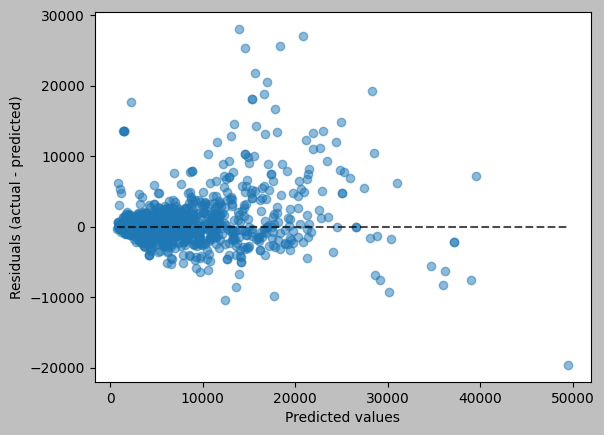

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe_all_transform.predict(X_val),
    kind="residual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
        line_kwargs = {"color" : 'black'}

);

Основная масса ошибок модели - сконцентрирована в диапазоне 1-2 тысячи

Но есть и крупномасштабные ошибки

С помощью логической индексации мы можем выделить те объекты, для которых значение ошибки большое

В идеале можно детальней посмотреть на распределение признаков для этой группы

In [ ]:
X_val.loc[np.abs(y_val-pipe_all_transform.predict(X_val))>10000,:]

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,random_feature_1,random_feature_2
3835,Porsche,Cayenne,2011,Crossover,46000.0,4800.0,Petrol,Automatic,0.284599,-1.468812
18867,Mercedes,M Class,2013,Crossover,111000.0,2143.0,Diesel,Automatic,0.380959,-0.267708
6237,Mercedes,E Class,2017,Sedan,203653.0,2000.0,Diesel,Automatic,0.537206,-1.988505
2208,Mercedes,C Class,2016,Sedan,30000.0,3000.0,Petrol,Automatic,0.350045,0.377372
2744,Lexus,GS Series,2016,Sedan,88000.0,3500.0,Hybrid,Automatic,0.678389,-1.099807
...,...,...,...,...,...,...,...,...,...,...
15963,Volkswagen,Touareg,2011,Crossover,185000.0,3000.0,Diesel,Automatic,0.565075,-0.381739
7298,Mercedes,S Class,2010,Sedan,291712.0,3000.0,Diesel,Automatic,0.502518,0.497747
13614,BMW,5 Series,2018,Sedan,29000.0,1998.0,Plug-in Hybrid,Automatic,0.062264,-1.028500
23657,Land Rover,Range Rover,2014,Crossover,190700.0,3000.0,Diesel,Automatic,0.839308,-2.150842


# CatBoost

Складываем в Pool

In [ ]:
train_data = Pool(
    data=X_train,
    label=y_train,
    cat_features = cat_columns,
    feature_names=list(X_train.columns)
)

eval_data = Pool(
    data=X_val,
    label=y_val,
    cat_features = cat_columns,
    feature_names=list(X_train.columns)
)

Готовим объект

In [ ]:
model_reg = CatBoostRegressor(iterations = 1000,
                           early_stopping_rounds=100,
                           verbose = 100,
                           cat_features = cat_columns,
                           depth = 3,
                           eval_metric= 'MAE'
                           )


Обучаем

In [ ]:
%%time
model_reg.fit(X=train_data,
          eval_set=eval_data,
          );

Learning rate set to 0.083159
0:	learn: 5341.6428495	test: 5427.6644559	best: 5427.6644559 (0)	total: 138ms	remaining: 2m 17s
100:	learn: 2049.4252973	test: 2073.1290595	best: 2073.1290595 (100)	total: 4.64s	remaining: 41.3s
200:	learn: 1922.6304901	test: 1953.1424278	best: 1953.1424278 (200)	total: 7.26s	remaining: 28.9s
300:	learn: 1876.3369569	test: 1913.2454247	best: 1913.2454247 (300)	total: 9.91s	remaining: 23s
400:	learn: 1840.3431374	test: 1884.8668050	best: 1884.8668050 (400)	total: 12.5s	remaining: 18.6s
500:	learn: 1812.0139507	test: 1863.6334589	best: 1863.6334589 (500)	total: 15.5s	remaining: 15.5s
600:	learn: 1789.4512229	test: 1850.3250814	best: 1850.3073400 (598)	total: 18.3s	remaining: 12.1s
700:	learn: 1772.5917788	test: 1839.7862412	best: 1839.7093299 (699)	total: 20.4s	remaining: 8.72s
800:	learn: 1756.1677365	test: 1828.4024918	best: 1828.3844018 (799)	total: 22.9s	remaining: 5.69s
900:	learn: 1741.2288223	test: 1819.0908300	best: 1819.0908300 (900)	total: 25.8s	re

## метрики модели

In [ ]:
analyse_model(model_reg,
              X_train, y_train,
              X_val, y_val,
              metrics, metric_names,
              scoring_reg, cv_rule,
              model_name = 'CatBoost',
              comments = 'MAE_all_features+random')

mse на тренировочной выборке: 8180823.1070
mse на валидационной выборке: 9125640.9686
r2_score на тренировочной выборке: 0.8655
r2_score на валидационной выборке: 0.8550
Learning rate set to 0.065966
0:	learn: 5420.9883662	total: 35ms	remaining: 34.9s
100:	learn: 2112.4809643	total: 2.23s	remaining: 19.8s
200:	learn: 1975.5569829	total: 3.51s	remaining: 14s
300:	learn: 1914.5623324	total: 4.25s	remaining: 9.86s
400:	learn: 1876.8074473	total: 5.03s	remaining: 7.51s
500:	learn: 1846.4224178	total: 5.8s	remaining: 5.78s
600:	learn: 1826.9412747	total: 6.56s	remaining: 4.35s
700:	learn: 1808.5331564	total: 7.33s	remaining: 3.13s
800:	learn: 1792.7718256	total: 8.14s	remaining: 2.02s
900:	learn: 1780.1507718	total: 8.96s	remaining: 985ms
999:	learn: 1768.4875738	total: 9.74s	remaining: 0us
Learning rate set to 0.065966
0:	learn: 5391.5222248	total: 10.4ms	remaining: 10.4s
100:	learn: 2098.3675546	total: 810ms	remaining: 7.21s
200:	learn: 1954.5253552	total: 2.4s	remaining: 9.55s
300:	learn

,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,10.062218,0.012943,0.858346,-8.387586e+06,-1758.834090,-26624.182499
1,10.072499,0.014261,0.863888,-8.800478e+06,-1771.653313,-36122.146720
2,9.859754,0.012617,0.843451,-9.610949e+06,-1788.445096,-39722.521300
3,8.808943,0.018708,0.857758,-8.495438e+06,-1808.153547,-19321.917493
4,9.656292,0.012447,0.843243,-9.180384e+06,-1766.629634,-41074.203635




test_R2      8.533374e-01
test_-MSE   -8.894967e+06
test_-MAE   -1.778743e+03
test_-Max   -3.257299e+04
dtype: float64


Метрики получше.

Переобучения вроде нет

## Feature Importance

In [ ]:
def feature_importance_plotter(model, features_names):
    # У CatBoost значимость признаков не нормированная
    feature_importance = model.feature_importances_/np.sum(model.feature_importances_)

    sorted = np.argsort(feature_importance)

    ypos = np.arange(len(features_names))

    fig= plt.figure(figsize=(8,4))
    plt.barh(ypos, feature_importance[sorted])
    plt.xlim([0,1])
    plt.ylabel('Признаки')
    plt.xlabel('Значимость')
    plt.yticks(ypos,features_names[sorted] );

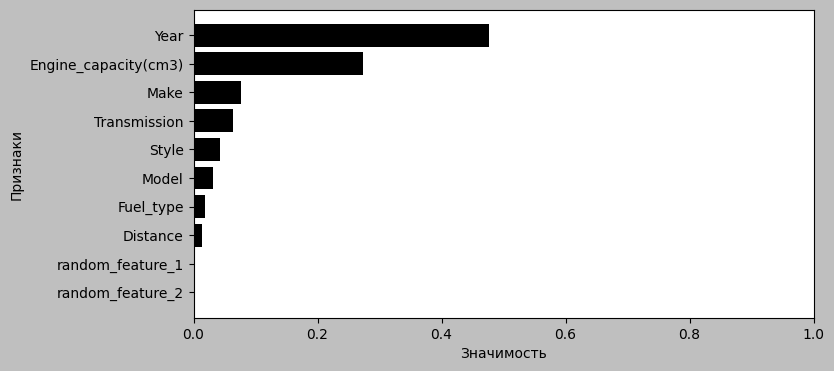

In [ ]:
feature_importance_plotter(model_reg, np.array(X_train.columns))

А вот тут важнее `Year` , `Engine_capacity(cm3)`, признаки `Make` и `Transmission` чуть менее важны

Радует что случайные признаки в нуле

## анализ ошибок

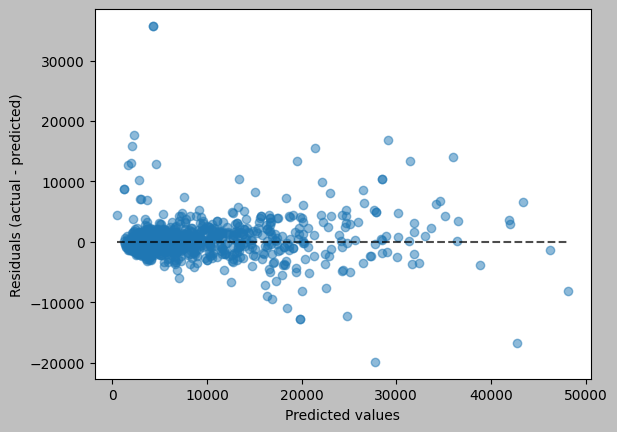

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model_reg.predict(eval_data),
    kind="residual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
        line_kwargs = {"color" : 'black'}

);

тут в среднем получше

Основные проблемы с дорогими автомобилями, которых не так много

In [ ]:
X_val.loc[np.abs(y_val-model_reg.predict(eval_data))>10000,:]

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,random_feature_1,random_feature_2
2001,BMW,3 Series,2018,Sedan,45000.0,2000.0,Plug-in Hybrid,Automatic,0.558813,-0.318845
25194,Audi,A6,2017,Sedan,222222.0,2700.0,Diesel,Manual,0.571273,-0.516804
25330,Nissan,Sunny,1995,Sedan,37998.0,1392.0,Metan/Propan,Manual,0.777424,-0.182151
27147,KIA,Carnival,2018,Minivan,67680.0,2199.0,Diesel,Automatic,0.544479,0.222315
19542,Volvo,XC60,2016,SUV,40000.0,2400.0,Diesel,Automatic,0.083988,-2.649413
...,...,...,...,...,...,...,...,...,...,...
6127,Mercedes,S Class,2014,Sedan,106029.0,2987.0,Diesel,Automatic,0.219918,0.361065
29327,Hyundai,Tucson,2019,SUV,25000.0,2000.0,Diesel,Automatic,0.699209,0.717066
21433,BMW,7 Series,2014,Sedan,74000.0,4400.0,Petrol,Automatic,0.397215,1.117336
23657,Land Rover,Range Rover,2014,Crossover,190700.0,3000.0,Diesel,Automatic,0.839308,-2.150842


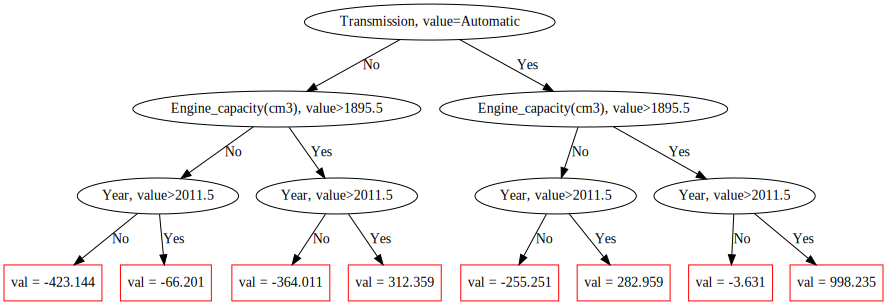

In [ ]:
#@title Глубина дерева для Отрисовки{ run: "auto" }
tree_idx=0 #@param {type:"slider", min:0, max:25, step:1}

model_reg.plot_tree(tree_idx=tree_idx,
                pool = train_data)

# Permutation importance

Есть в `scikit-learn`

Это про то что будет если какую-то переменную перемешать (в рамках столбца). Если от перемешивания результат меняется - то наверное признак важный

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
%%time
perm_importance_lin = permutation_importance(pipe_all_transform, # модель / pipeline
                                         X_val, # признаки
                                         y_val, # метки
                                         n_repeats=5, # сколько раз делать перемешивание
                                         random_state=42)

CPU times: user 3.4 s, sys: 2.29 s, total: 5.69 s
Wall time: 5.96 s


Визуализируем как `feature importance` от деревьев решений / бустингов

In [ ]:
def permutation_importance_plotter(perm_importance, cols):
    sorted_idx = perm_importance.importances_mean.argsort()
    fig = plt.figure(figsize=(12, 5))
    plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), cols[sorted_idx])
    plt.title('Permutation Importance');

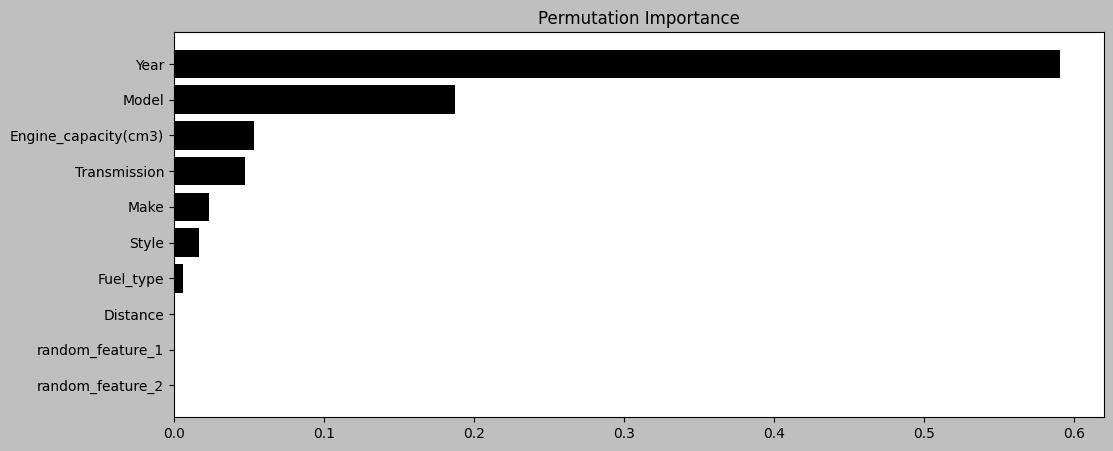

In [ ]:
permutation_importance_plotter(perm_importance_lin, np.array(X_val.columns))

для линейной модели первые два признака оказались значимыми как и в весах модели

При этом поднялся `Engine_capacity(cm3)`

In [ ]:
%%time
perm_importance_cb = permutation_importance(model_reg, # модель / pipeline
                                         X_val, # признаки
                                         y_val, # метки
                                         n_repeats=5, # сколько раз делать перемешивание
                                         random_state=42)

CPU times: user 3.07 s, sys: 80.2 ms, total: 3.15 s
Wall time: 2.7 s


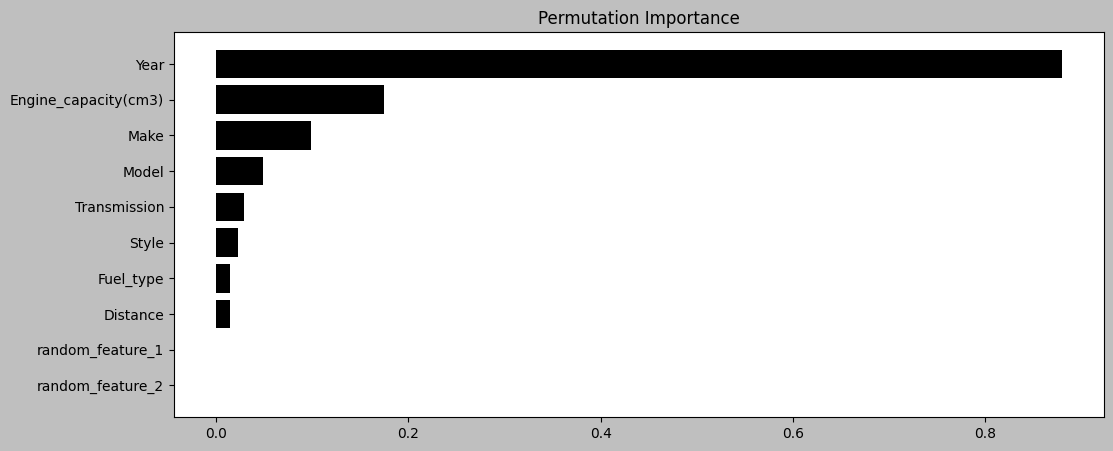

In [ ]:
permutation_importance_plotter(perm_importance_cb, np.array(X_val.columns))

Для бустинга история вроде совпадает с простым Feature Importance

# Partial plots

История о том как отдельный признак влияет на целевую метку

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

CPU times: user 28.4 s, sys: 18.8 s, total: 47.2 s
Wall time: 38.1 s


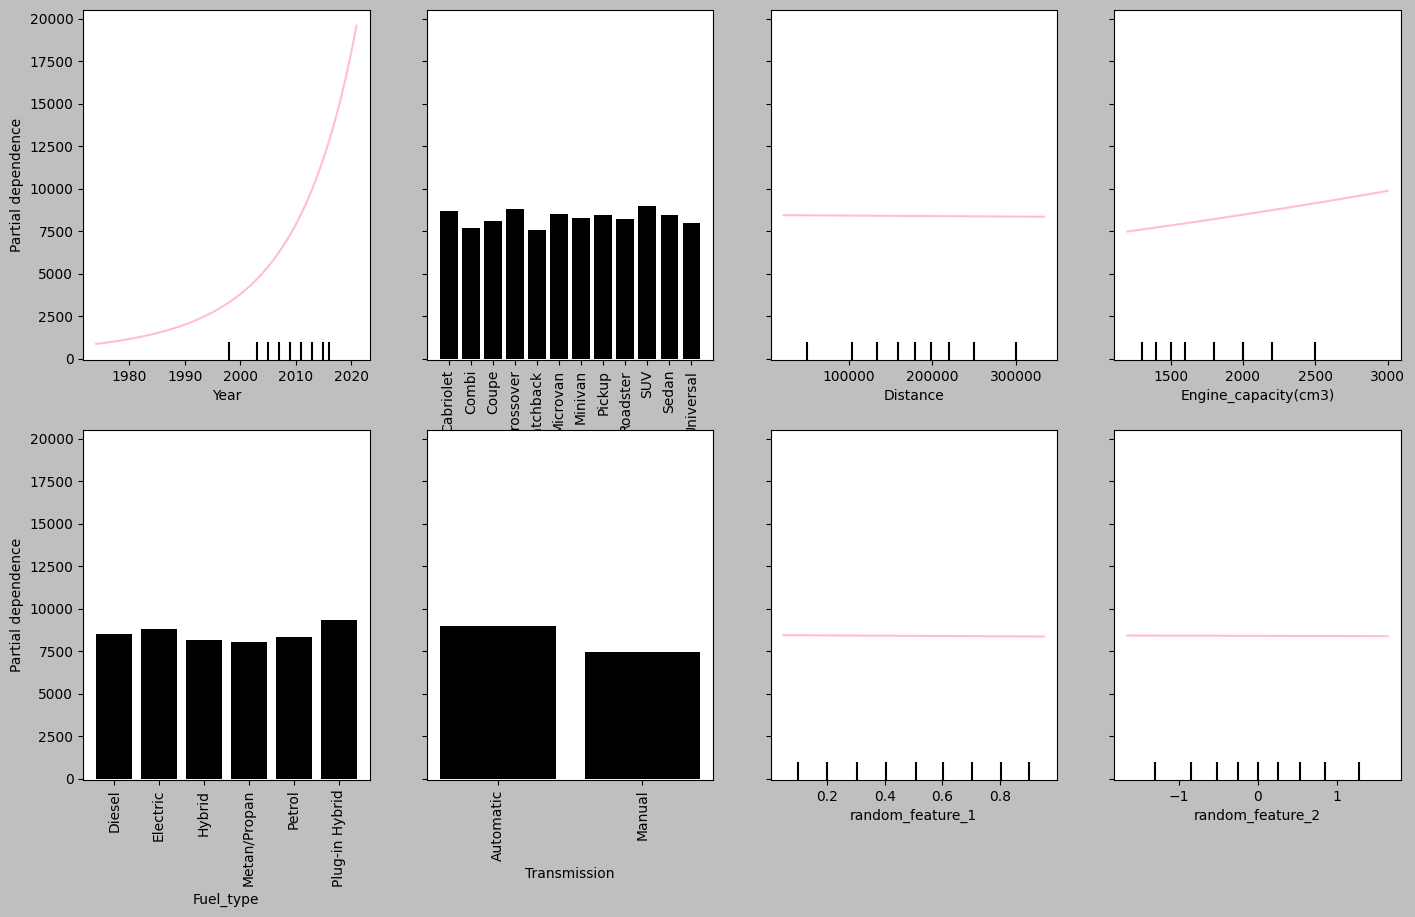

In [ ]:
%%time
fig, ax = plt.subplots(figsize=(17, 10))
PDD = PartialDependenceDisplay.from_estimator(pipe_all_transform, # модель / pipeline
                                        X_val, # признаки
                                        features = X_val.columns[2:], # какие признаки проверять будем
                                        categorical_features = cat_columns, # какие признаки категориальные
                                        kind="average",
                                        n_cols = 4, # для отрисовки - сколько столбцов
                                        random_state=42,
                                        line_kw = {"color" : 'pink'},
                                        ax=ax);


Для линейной модели наблюдаем подобие линейной зависимости для объема двигателя и пробега (хотя так себе, если честно для пробега) и близкое к экспоненциальному зависимоть от года (не зря делали степенное преобразование)

Для разных категорий наблюдаются разные цены, но это мы и раньше могли догадываться

CPU times: user 26.9 s, sys: 1.01 s, total: 27.9 s
Wall time: 18.8 s


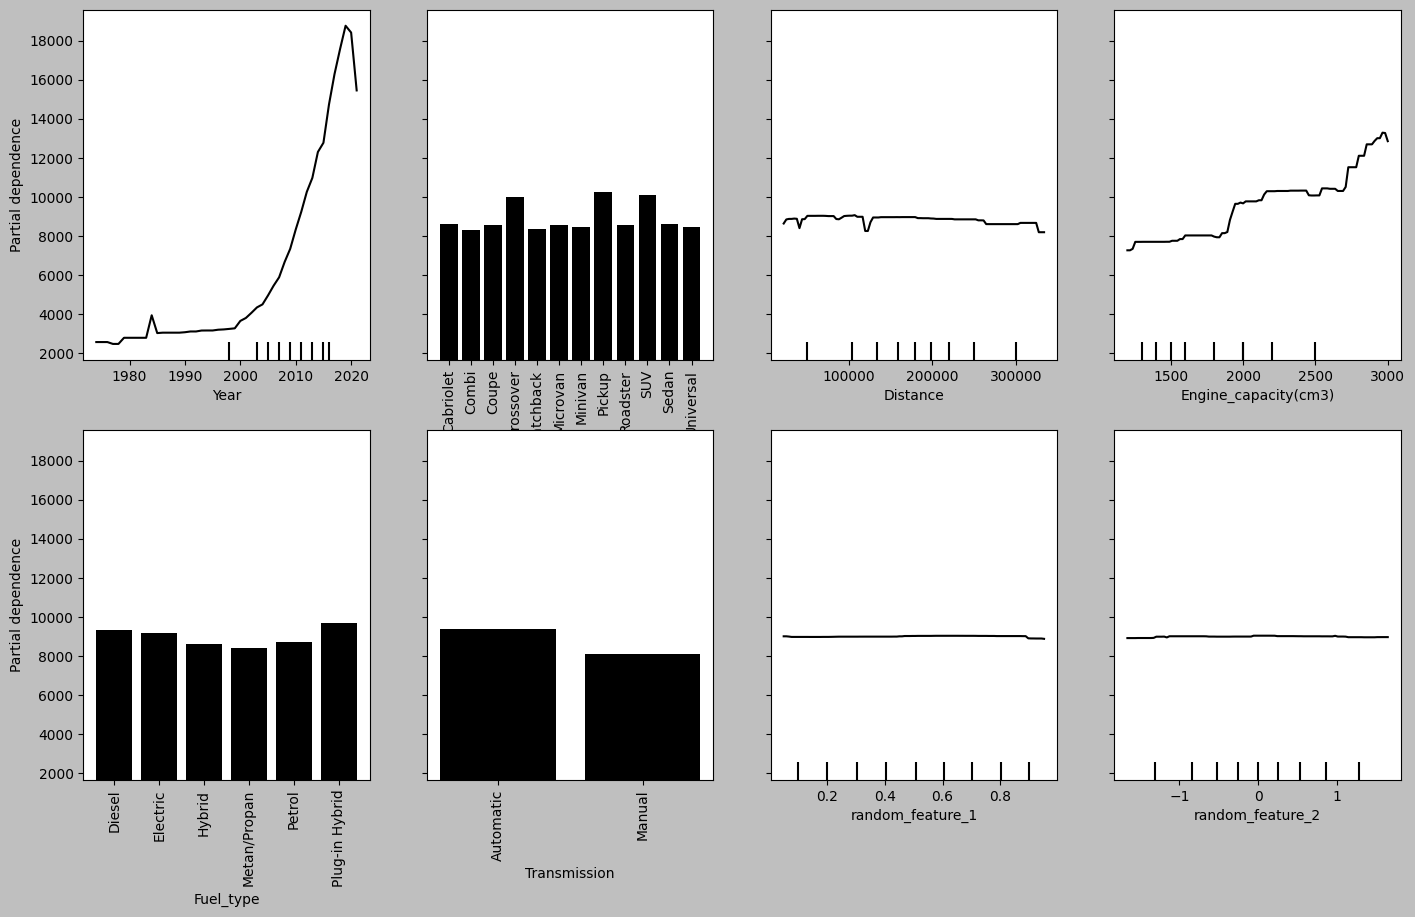

In [ ]:
%%time
fig, ax = plt.subplots(figsize=(17, 10))
PDD = PartialDependenceDisplay.from_estimator(model_reg, # модель / pipeline
                                        X_val, # признаки
                                        features = X_val.columns[2:], # какие признаки проверять будем
                                        categorical_features = cat_columns, # какие признаки категориальные
                                        kind="average",
                                        n_cols = 4, # для отрисовки - сколько столбцов
                                        random_state=42,
                                        ax=ax);


Для бустингов числовые значения менее плавно зависят, но это и более честно

Зависимость категориальных признаков немного изменилась

#  Резуультаты сравнения моделей

In [ ]:
results = pd.read_csv('model_results.csv')
results

,Model,Comments,Train mse,Train r2_score,Val mse,Val r2_score,CV test_R2 mean,CV test_R2 std,CV test_R2 Fold 1,CV test_R2 Fold 2,...,CV test_-MAE Fold 3,CV test_-MAE Fold 4,CV test_-MAE Fold 5,CV test_-Max mean,CV test_-Max std,CV test_-Max Fold 1,CV test_-Max Fold 2,CV test_-Max Fold 3,CV test_-Max Fold 4,CV test_-Max Fold 5
0,SGDRegression,num_scale+cat_TE+target_transform+random,1.424068e+07,0.765810,1.567179e+07,0.751069,0.758987,0.010822,0.760078,0.761637,...,-2133.780311,-2243.198575,-2194.787907,-35381.197004,5353.033137,-30777.625417,-38147.776899,-39470.916683,-27356.833865,-41152.832154
1,CatBoost,MAE_all_features+random,8.180823e+06,0.865465,9.125641e+06,0.855048,0.853337,0.008433,0.858346,0.863888,...,-1788.445096,-1808.153547,-1766.629634,-32572.994329,8330.212215,-26624.182499,-36122.146720,-39722.521300,-19321.917493,-41074.203635
